In [1]:
"""
Copyright 2021 Huawei Technologies Co., Ltd

CREATED:  2022-10-04 13:12:13
MODIFIED: 2022-10-06 10:48:45
"""

# -*- coding:utf-8 -*-
import sys
sys.path.append('../acllite')
from acllite_model import AclLiteModel
from acllite_resource import AclLiteResource
from acllite_imageproc import AclLiteImageProc
from acllite_image import AclLiteImage
from processes import get_model_info, construct_image_info, pre_process, post_processing

import acl, cv2, struct, time, os
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw
from IPython import display

In [2]:
with open("data/coco.names") as fd:
    coco_labels = fd.readlines()

coco_labels = [i[:-1] for i in coco_labels][1:]

In [3]:
model_path = "/home/altemur/acllite_update/models/yolov3_caffe_dvpp/yolov3_caffe_dvpp.om"
img_path = "./data/kite.jpg"

MODEL_WIDTH = 416
MODEL_HEIGHT = 416

acl_resource = AclLiteResource()
acl_resource.init()

model = AclLiteModel(model_path, 0)

init resource stage:
Init resource success
Init model resource start...
[AclLiteModel] create model output dataset:
malloc output 0, size 24576
malloc output 1, size 32
Create model output dataset success
Init model resource success
Init model resource start...
[AclLiteModel] create model output dataset:
malloc output 0, size 24576
malloc output 1, size 32
Create model output dataset success
Init model resource success
Init model resource start...
[AclLiteModel] create model output dataset:
malloc output 0, size 24576
malloc output 1, size 32
Create model output dataset success
Init model resource success


In [4]:
get_model_info(model)

	Input Dimensions
Name: data
Dimensions: [1, 416, 416, 3]
---------------------------------
Name: img_info
Dimensions: [1, 4]
---------------------------------


	Output Dimensions
Name: detection_out3:0:box_out
Dimensions: [1, 6144]
---------------------------------
Name: detection_out3:1:box_out_num
Dimensions: [1, 8]
---------------------------------


In [5]:
dvpp = AclLiteImageProc(acl_resource)

In [6]:
image = AclLiteImage(img_path)
bgr_img = cv2.imread(img_path)
#preprocess image
resized_image = pre_process(image, dvpp)

decode jpeg end
[AclLiteImageProc] vpc crop and paste stage:
[AclLiteImageProc] vpc crop and paste stage success
resize yuv end


In [7]:
result_list = model.execute([resized_image, construct_image_info()]) 

In [8]:
result_list

[array([[35.75      , 25.1875    ,  9.34375   , ...,  0.05224609,
          0.2084961 ,  0.5205078 ]], dtype=float32),
 array([[        10, 1425036528, 1425036528, 1425036528, 1425036528,
         1425036528, 1425036528, 1425036528]], dtype=int32)]

In [9]:
boxes = post_processing(result_list)
pd.DataFrame(boxes)

,x1,y1,x2,y2,detection_scores,detection_classes,class_label
0,35.75000,190.5000,51.84375,233.2500,0.993164,0.0,person
1,25.18750,157.2500,33.06250,174.5000,0.980469,0.0,person
2,9.34375,159.2500,16.15625,171.7500,0.930664,0.0,person
3,54.84375,167.3750,60.87500,176.8750,0.927734,0.0,person
4,107.25000,151.1250,110.18750,156.3750,0.914062,0.0,person
5,159.62500,154.3750,165.62500,163.2500,0.872559,0.0,person
6,66.25000,214.5000,83.25000,261.7500,0.872559,0.0,person
7,166.50000,160.5000,171.87500,165.5000,0.592773,0.0,person
8,182.37500,24.3750,207.00000,48.9375,0.847168,33.0,kite
9,86.12500,72.3125,94.62500,88.8750,0.608398,33.0,kite


In [10]:
img = Image.open(img_path)

scalex = img.size[0]/MODEL_HEIGHT

img1 = ImageDraw.Draw(img)
for box in boxes:
    img1.rectangle([box["x1"] * scalex,
                    box["y1"] * scalex,
                    box["x2"] * scalex,
                    box["y2"] * scalex], outline ="red", width=2)
    print(box["x1"], box["y1"], box["x2"], box["y2"], box["detection_scores"], box["detection_classes"], coco_labels[int(box["detection_classes"])])

35.75 190.5 51.84375 233.25 0.9931640625 0.0 person
25.1875 157.25 33.0625 174.5 0.98046875 0.0 person
9.34375 159.25 16.15625 171.75 0.9306640625 0.0 person
54.84375 167.375 60.875 176.875 0.927734375 0.0 person
107.25 151.125 110.1875 156.375 0.9140625 0.0 person
159.625 154.375 165.625 163.25 0.87255859375 0.0 person
66.25 214.5 83.25 261.75 0.87255859375 0.0 person
166.5 160.5 171.875 165.5 0.5927734375 0.0 person
182.375 24.375 207.0 48.9375 0.84716796875 33.0 kite
86.125 72.3125 94.625 88.875 0.6083984375 33.0 kite


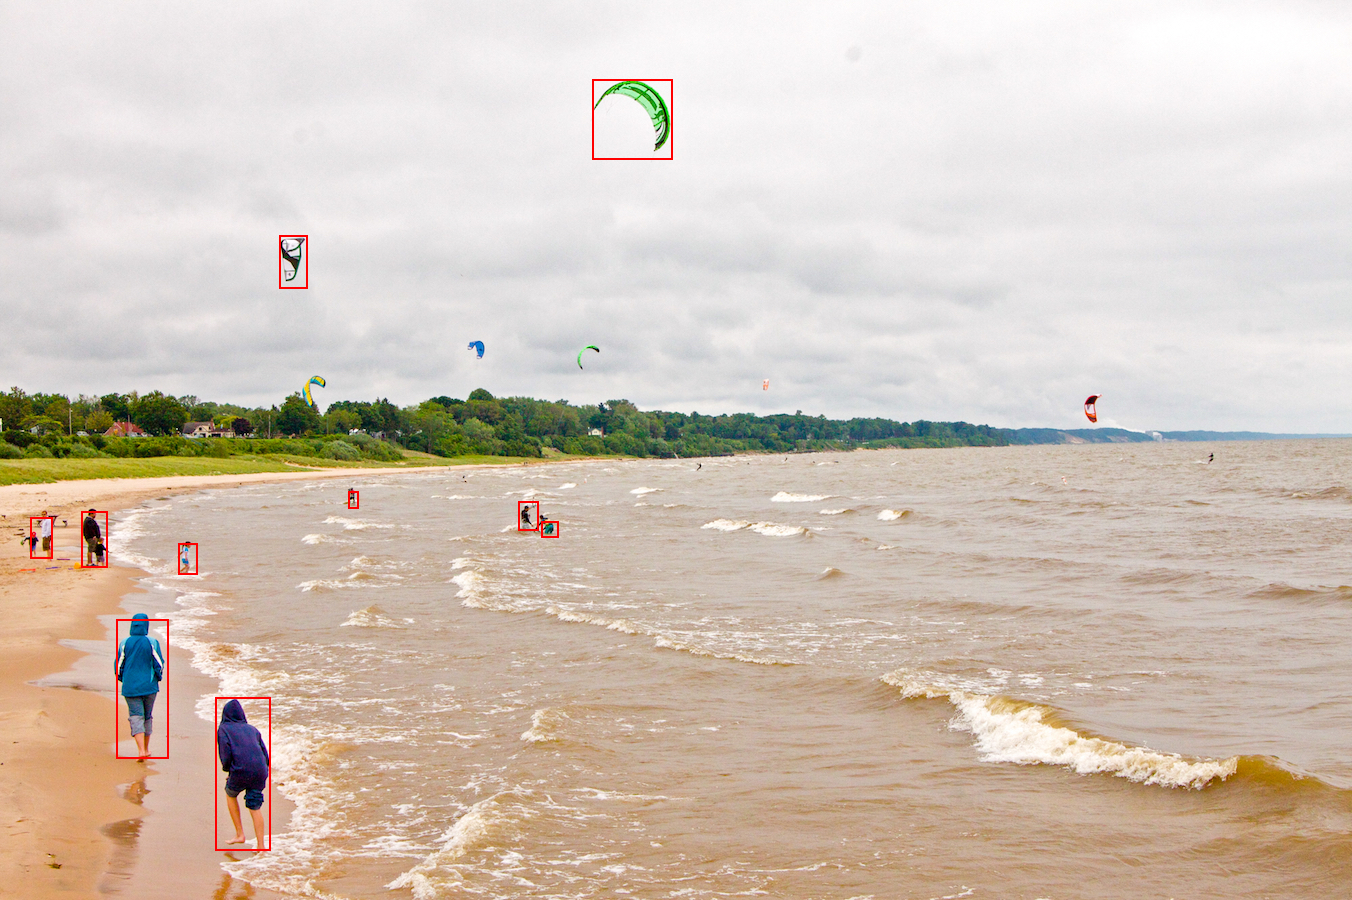

In [11]:
img